In [ ]:
# %pip install -U pandas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### data

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    "flower_photos.tar", origin=dataset_url, extract=True
)
data_dir = pathlib.Path(data_dir).with_suffix("")

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step


In [3]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(data_dir)
for dir in data_dir.iterdir():
    print(dir)
print(image_count)

C:\Users\yzdom\.keras\datasets\flower_photos
C:\Users\yzdom\.keras\datasets\flower_photos\daisy
C:\Users\yzdom\.keras\datasets\flower_photos\dandelion
C:\Users\yzdom\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\yzdom\.keras\datasets\flower_photos\roses
C:\Users\yzdom\.keras\datasets\flower_photos\sunflowers
C:\Users\yzdom\.keras\datasets\flower_photos\tulips
3670


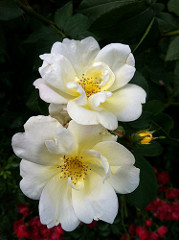

In [6]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

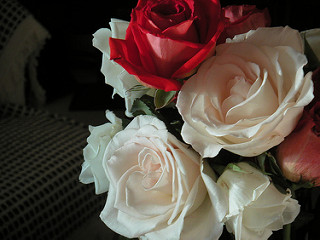

In [7]:
PIL.Image.open(str(roses[1]))

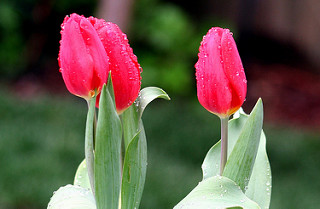

In [8]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

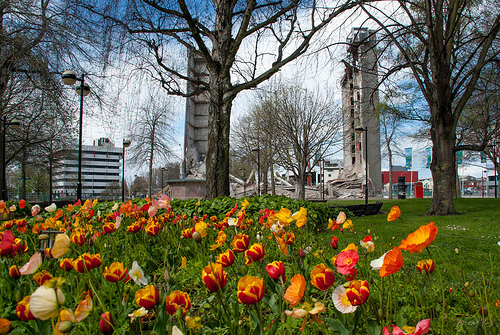

In [9]:
PIL.Image.open(str(tulips[-1]))

In [10]:
types = ["roses", "daisy", "dandelion", "sunflowers", "tulips"]
for t in types:
    print(t, len(list(data_dir.glob(t + "/*"))))

roses 641
daisy 633
dandelion 898
sunflowers 699
tulips 799


In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### vis

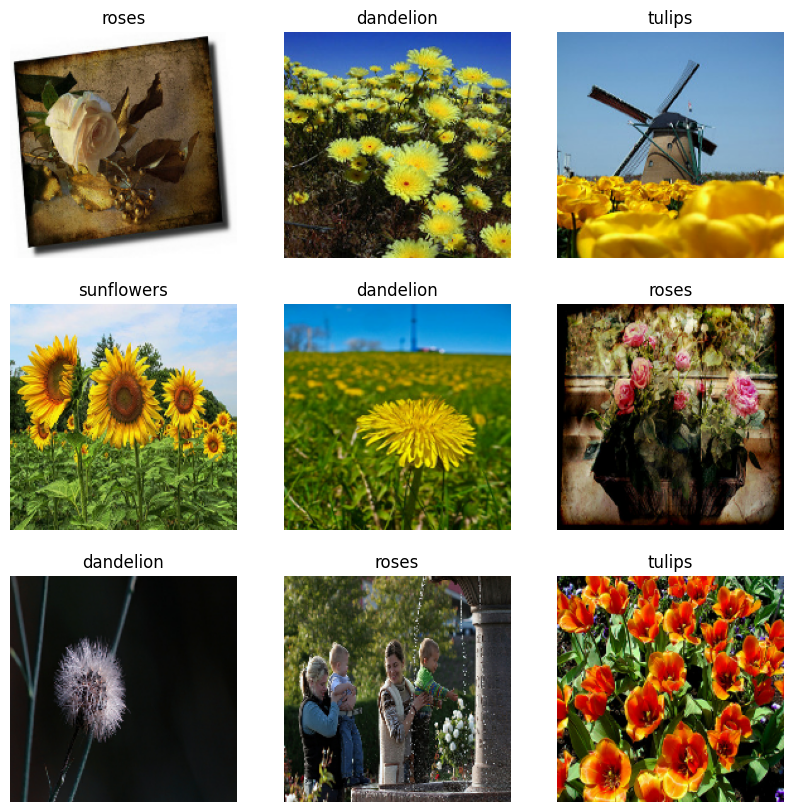

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [23]:
print(type(train_ds))
print(type(train_ds.take(1)))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>


In [27]:
for i, j in train_ds.take(2):
    print(f"{type(i)=}")
    print(f"{j=}")
    print(f"{len(j)=}")

type(i)=<class 'tensorflow.python.framework.ops.EagerTensor'>
j=<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([4, 4, 2, 0, 3, 4, 4, 4, 2, 1, 0, 3, 2, 2, 3, 1, 0, 2, 1, 2, 1, 4,
       1, 4, 3, 0, 4, 1, 1, 3, 2, 2])>
len(j)=32
type(i)=<class 'tensorflow.python.framework.ops.EagerTensor'>
j=<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 3, 2, 4, 2, 0, 3, 0, 4, 3, 2, 1, 0, 1, 1, 4, 3, 3, 2, 4, 2, 4,
       0, 3, 3, 1, 1, 3, 1, 2, 4, 0])>
len(j)=32


In [28]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [36]:
import itertools


def take(iterable, n):
    return list(itertools.islice(iterable, n))


for image_batch, labels_batch in take(train_ds, 1):
    print(f"{image_batch.shape=}")
    print(f"{labels_batch.shape=}")

    print(f"{image_batch[0].shape=}")
    print(f"{image_batch[0].numpy().astype('uint8').shape=}")

    print(f"{labels_batch[0].shape=}")
    print(f"{labels_batch[0]=}")

    print(f"{labels_batch[0].numpy()=}")
    print(f"{class_names[labels_batch[0].numpy()]=}")

image_batch.shape=TensorShape([32, 180, 180, 3])
labels_batch.shape=TensorShape([32])
image_batch[0].shape=TensorShape([180, 180, 3])
image_batch[0].numpy().astype('uint8').shape=(180, 180, 3)
labels_batch[0].shape=TensorShape([])
labels_batch[0]=<tf.Tensor: shape=(), dtype=int32, numpy=1>
labels_batch[0].numpy()=1
class_names[labels_batch[0].numpy()]='dandelion'


### config

In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
AUTOTUNE

-1

### std

In [39]:
normalization_layer = layers.Rescaling(1.0 / 255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### keras - create

In [40]:
num_classes = len(class_names)

model = Sequential(
    [
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes),
    ]
)

c:\Users\yzdom\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### keras - compile

In [41]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### keras - summary

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)      │        448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)        │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 30976)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │  3,965,056 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 5)                 │        645 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### keras - train


In [43]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.3411 - loss: 1.4950 - val_accuracy: 0.5586 - val_loss: 1.1020
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.5786 - loss: 1.0329 - val_accuracy: 0.5300 - val_loss: 1.0949
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.6654 - loss: 0.8681 - val_accuracy: 0.6485 - val_loss: 0.8679
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - accuracy: 0.7540 - loss: 0.6649 - val_accuracy: 0.6757 - val_loss: 0.8260
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.8573 - loss: 0.4126 - val_accuracy: 0.6907 - val_loss: 0.9095
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.9063 - loss: 0.2764 - val_accuracy: 0.6608 - val_loss: 1.0053
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.9635 - loss: 0.1446 - val_accuracy: 0.6621 - val_loss: 1.2308
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9749 - loss: 0.0949 - val_accu

### vis train


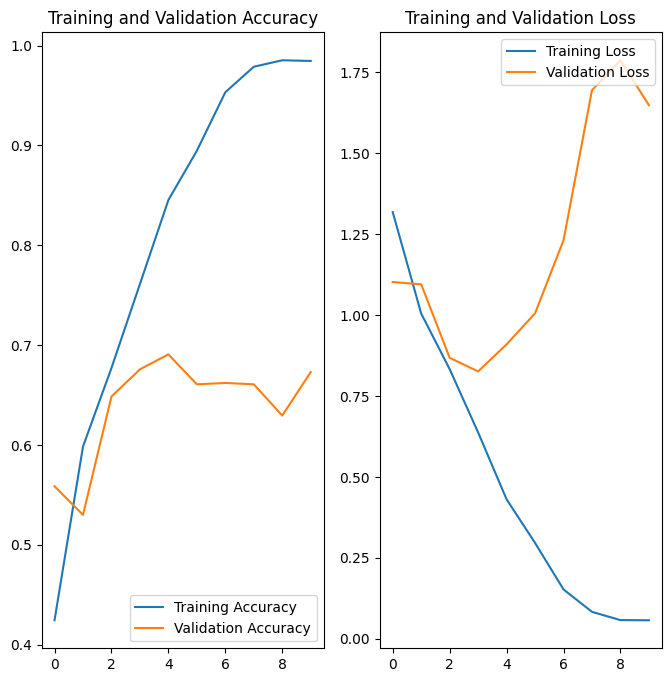

In [44]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

## take 2


### data aug


In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

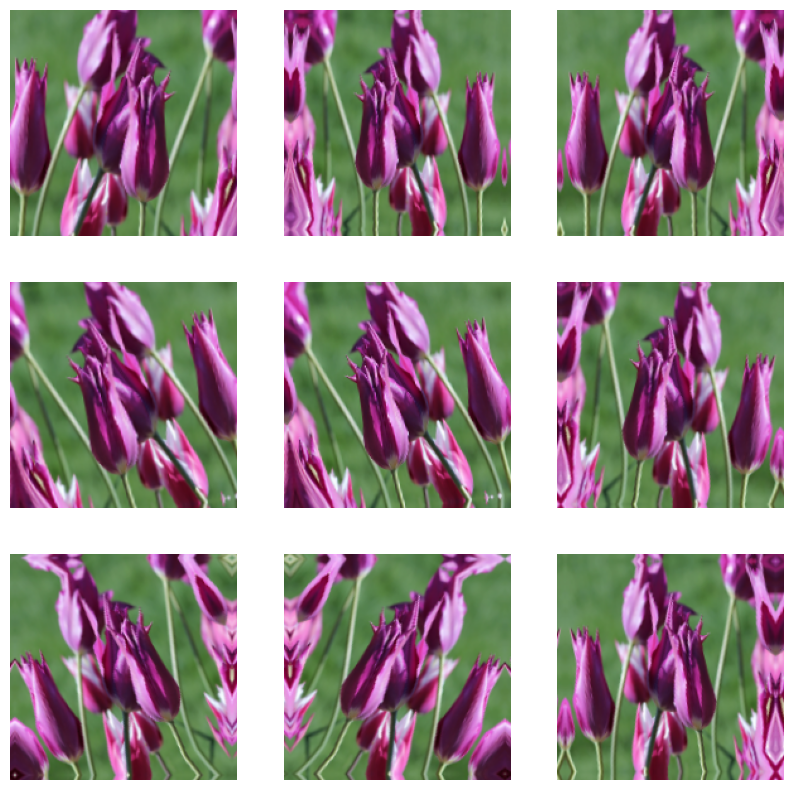

In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.axis("off")

### also add drop out on the new model


In [48]:
model = Sequential(
    [
        data_augmentation,
        layers.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, name="outputs"),
    ]
)

### compile and train


In [50]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rescaling_2 (Rescaling)         │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ outputs (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### vis train


In [51]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 244ms/step - accuracy: 0.4042 - loss: 1.3937 - val_accuracy: 0.5926 - val_loss: 1.0528
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.6133 - loss: 1.0199 - val_accuracy: 0.6172 - val_loss: 0.9691
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.6438 - loss: 0.8898 - val_accuracy: 0.6349 - val_loss: 0.9799
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.6756 - loss: 0.8545 - val_accuracy: 0.6553 - val_loss: 0.8788
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - accuracy: 0.6918 - loss: 0.7931 - val_accuracy: 0.6662 - val_loss: 0.8566
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.7148 - loss: 0.7745 - val_accuracy: 0.6757 - val_loss: 0.9372
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.7238 - loss: 0.7114 - val_accuracy: 0.7016 - val_loss: 0.7755
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.7262 - loss: 0.6763 - val_accu

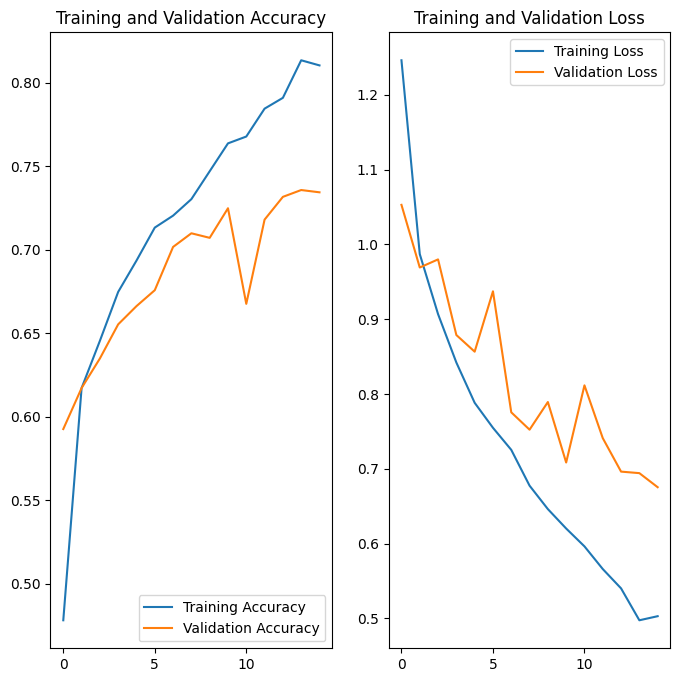

In [52]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

### preditct on new


In [53]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file("Red_sunflower", origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    )
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
This image most likely belongs to sunflowers with a 96.49 percent confidence.


### tf lite - convert


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

### tf lite - run

In [ ]:
TF_MODEL_FILE_PATH = (
    "model.tflite"  # The default path to the saved TensorFlow Lite model
)

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

In [ ]:
classify_lite = interpreter.get_signature_runner("serving_default")
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)["outputs"]
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
        class_names[np.argmax(score_lite)], 100 * np.max(score_lite)
    )
)

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))